In [1]:
import numpy as np
import pandas as pd

import dask.dataframe as dd
from pathlib import Path
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors

In [2]:
import sys

sys.path.append("../src")

In [3]:
import data_handling as dh
import subsampling as ss
from core import SITE_NAMES, FREQ_GROUPS

from cli import get_file_paths
import plotting
import pipeline

In [4]:
type_key = ''
site_key = "Central"
cycle_lengths = [1800, 360]
percent_ons = [0.1667]
specific_dc_tag = "1800of1800"

In [5]:
pipeline_params = dict()
pipeline_params["read_csv"] = False
pipeline_params["save_activity_grid"] = True
pipeline_params["save_presence_grid"] = True
pipeline_params["save_dc_night_comparisons"] = True
pipeline_params["save_activity_dc_comparisons"] = True
pipeline_params["save_presence_dc_comparisons"] = True
pipeline_params["show_plots"] = False
pipeline_params["show_PST"] = True
pipeline_params

{'read_csv': False,
 'save_activity_grid': True,
 'save_presence_grid': True,
 'save_dc_night_comparisons': True,
 'save_activity_dc_comparisons': True,
 'save_presence_dc_comparisons': True,
 'show_plots': False,
 'show_PST': True}

In [6]:
data_params = dict()
data_params["site_name"] = SITE_NAMES[site_key]
data_params["site_tag"] = site_key
data_params["type_tag"] = type_key
data_params["freq_tags"] = FREQ_GROUPS[type_key]
data_params["cycle_lengths"] = cycle_lengths
data_params["percent_ons"] = percent_ons
dc_tags = ss.get_list_of_dc_tags(data_params["cycle_lengths"], data_params["percent_ons"])
data_params["dc_tags"] = dc_tags
data_params["cur_dc_tag"] = specific_dc_tag
data_params['resolution'] = '30T'
data_params

{'site_name': 'Central Pond',
 'site_tag': 'Central',
 'type_tag': '',
 'freq_tags': [0, 125000],
 'cycle_lengths': [1800, 360],
 'percent_ons': [0.1667],
 'dc_tags': ['1800of1800', '300of1800', '60of360'],
 'cur_dc_tag': '1800of1800',
 'resolution': '30T'}

In [7]:
file_paths = get_file_paths(data_params)

In [8]:
# dc_tag = data_params["cur_dc_tag"]
# location_df = ss.prepare_summary_for_plotting_with_duty_cycle(file_paths, dc_tag)
# location_df

In [9]:
activity_arr = pipeline.run(data_params, pipeline_params, file_paths)

In [10]:
activity_arr[:21]

,Number_of_Detections (1800of1800),Number_of_Detections (300of1800),Number_of_Detections (60of360)
Date_and_Time_UTC,,,
2022-08-09 03:00:00,0.0,0.0,0.0
2022-08-09 03:30:00,0.0,0.0,0.0
2022-08-09 04:00:00,15.0,0.0,2.0
2022-08-09 04:30:00,283.0,9.0,17.0
2022-08-09 05:00:00,657.0,40.0,59.0
2022-08-09 05:30:00,517.0,176.0,86.0
2022-08-09 06:00:00,108.0,31.0,0.0
2022-08-09 06:30:00,186.0,6.0,19.0
2022-08-09 07:00:00,196.0,22.0,38.0


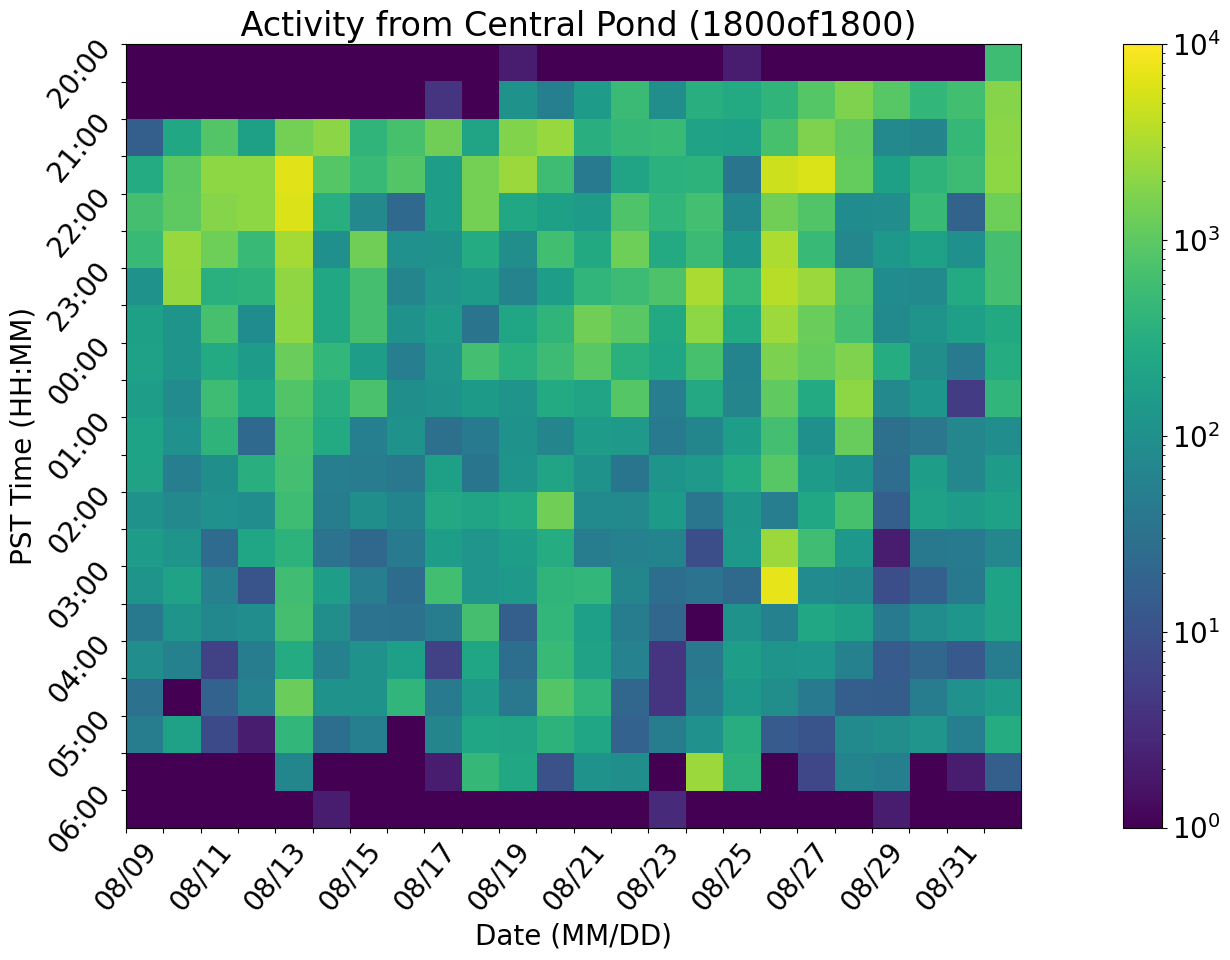

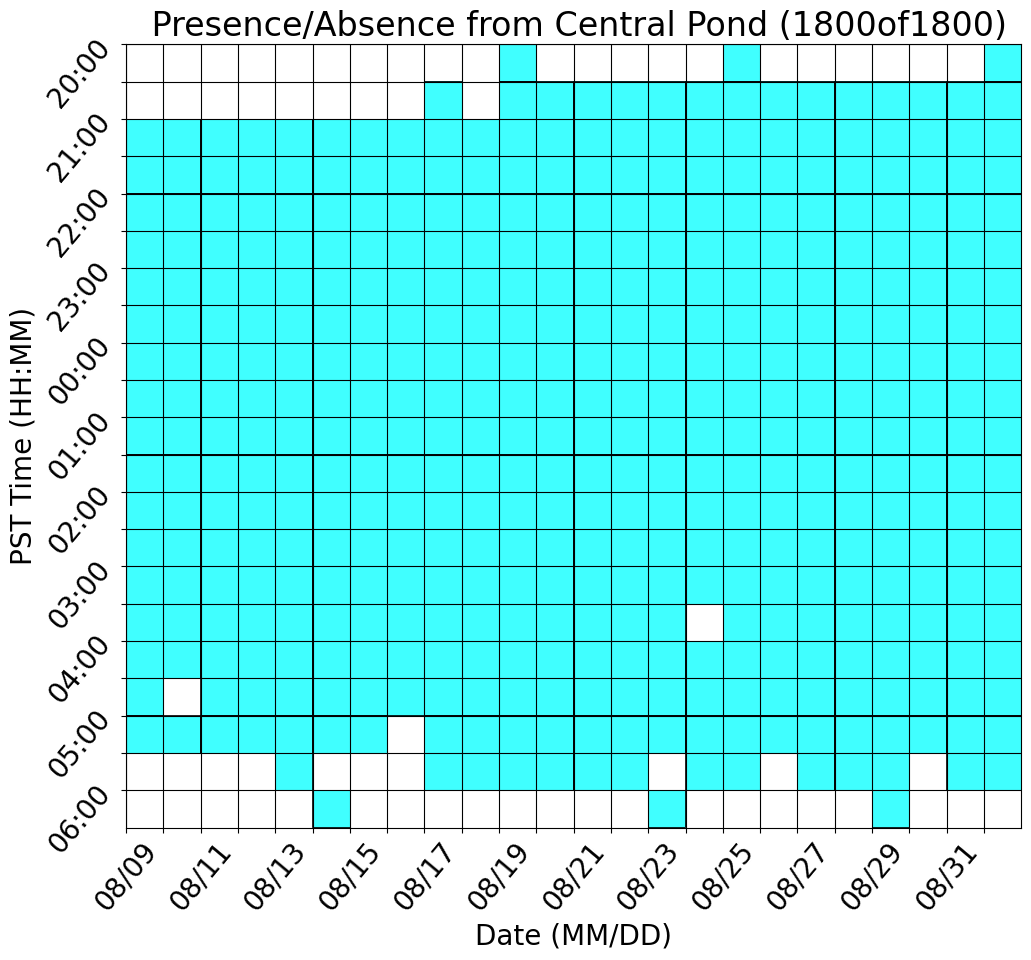

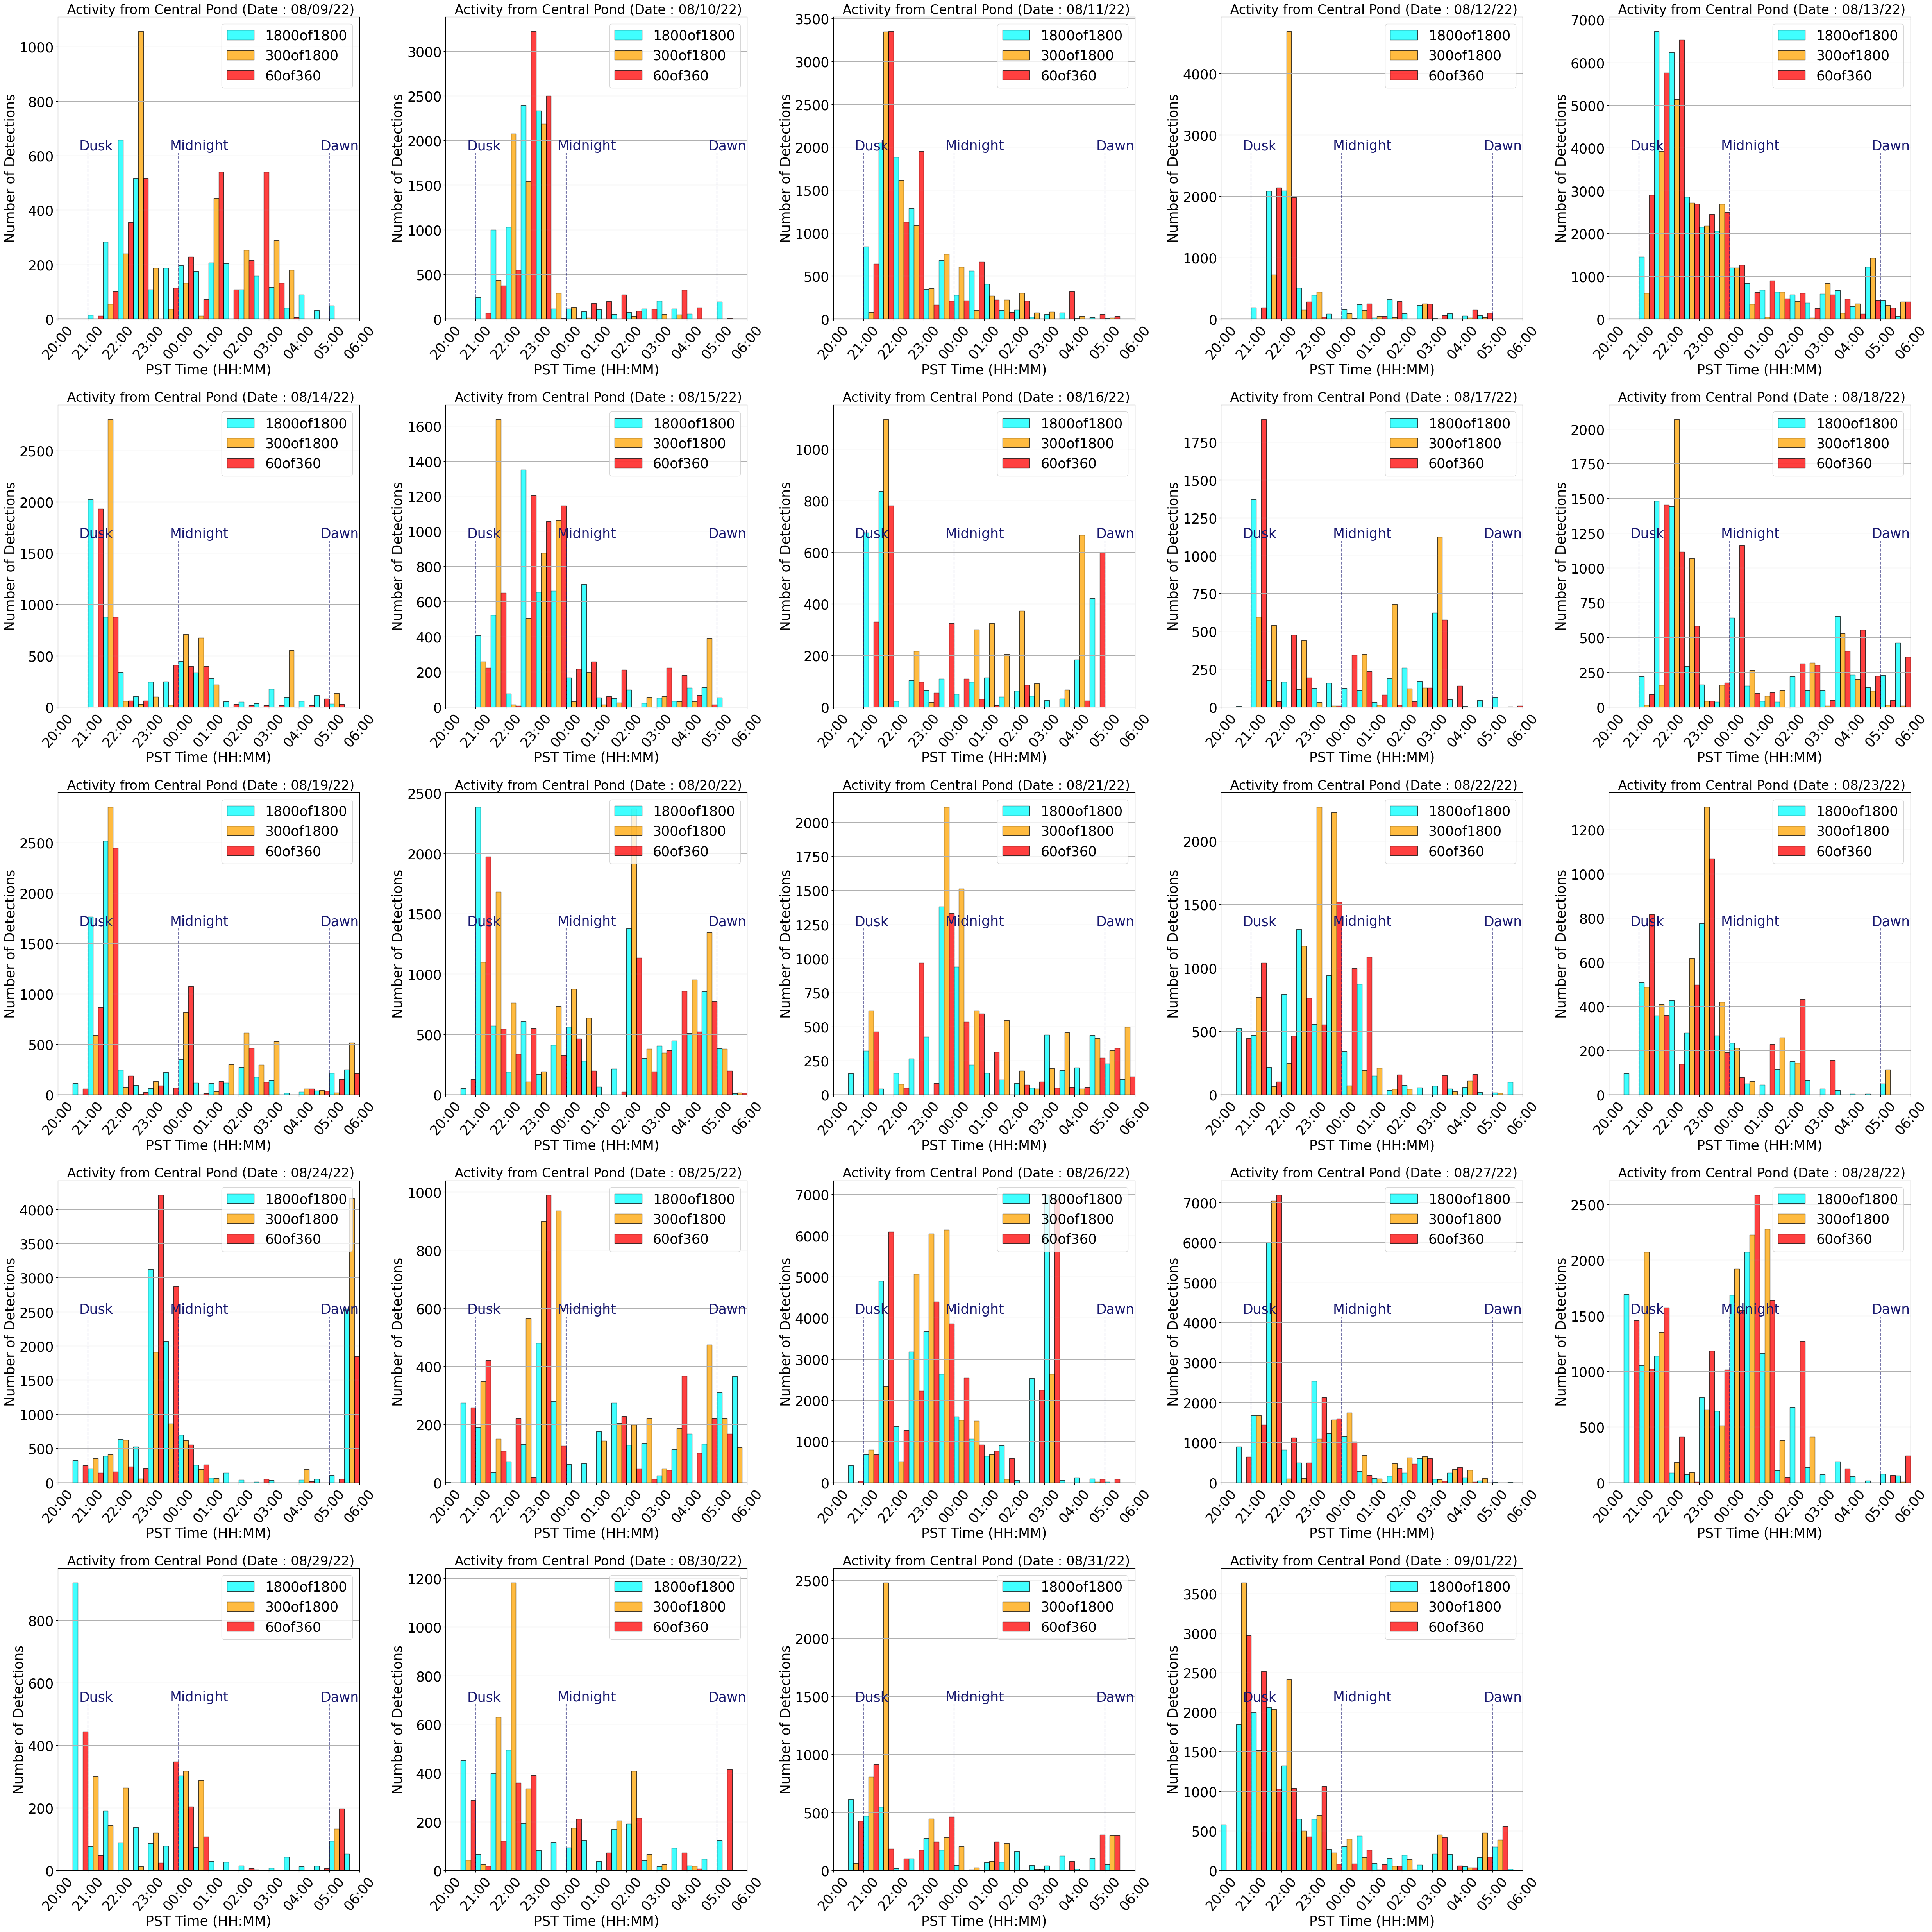

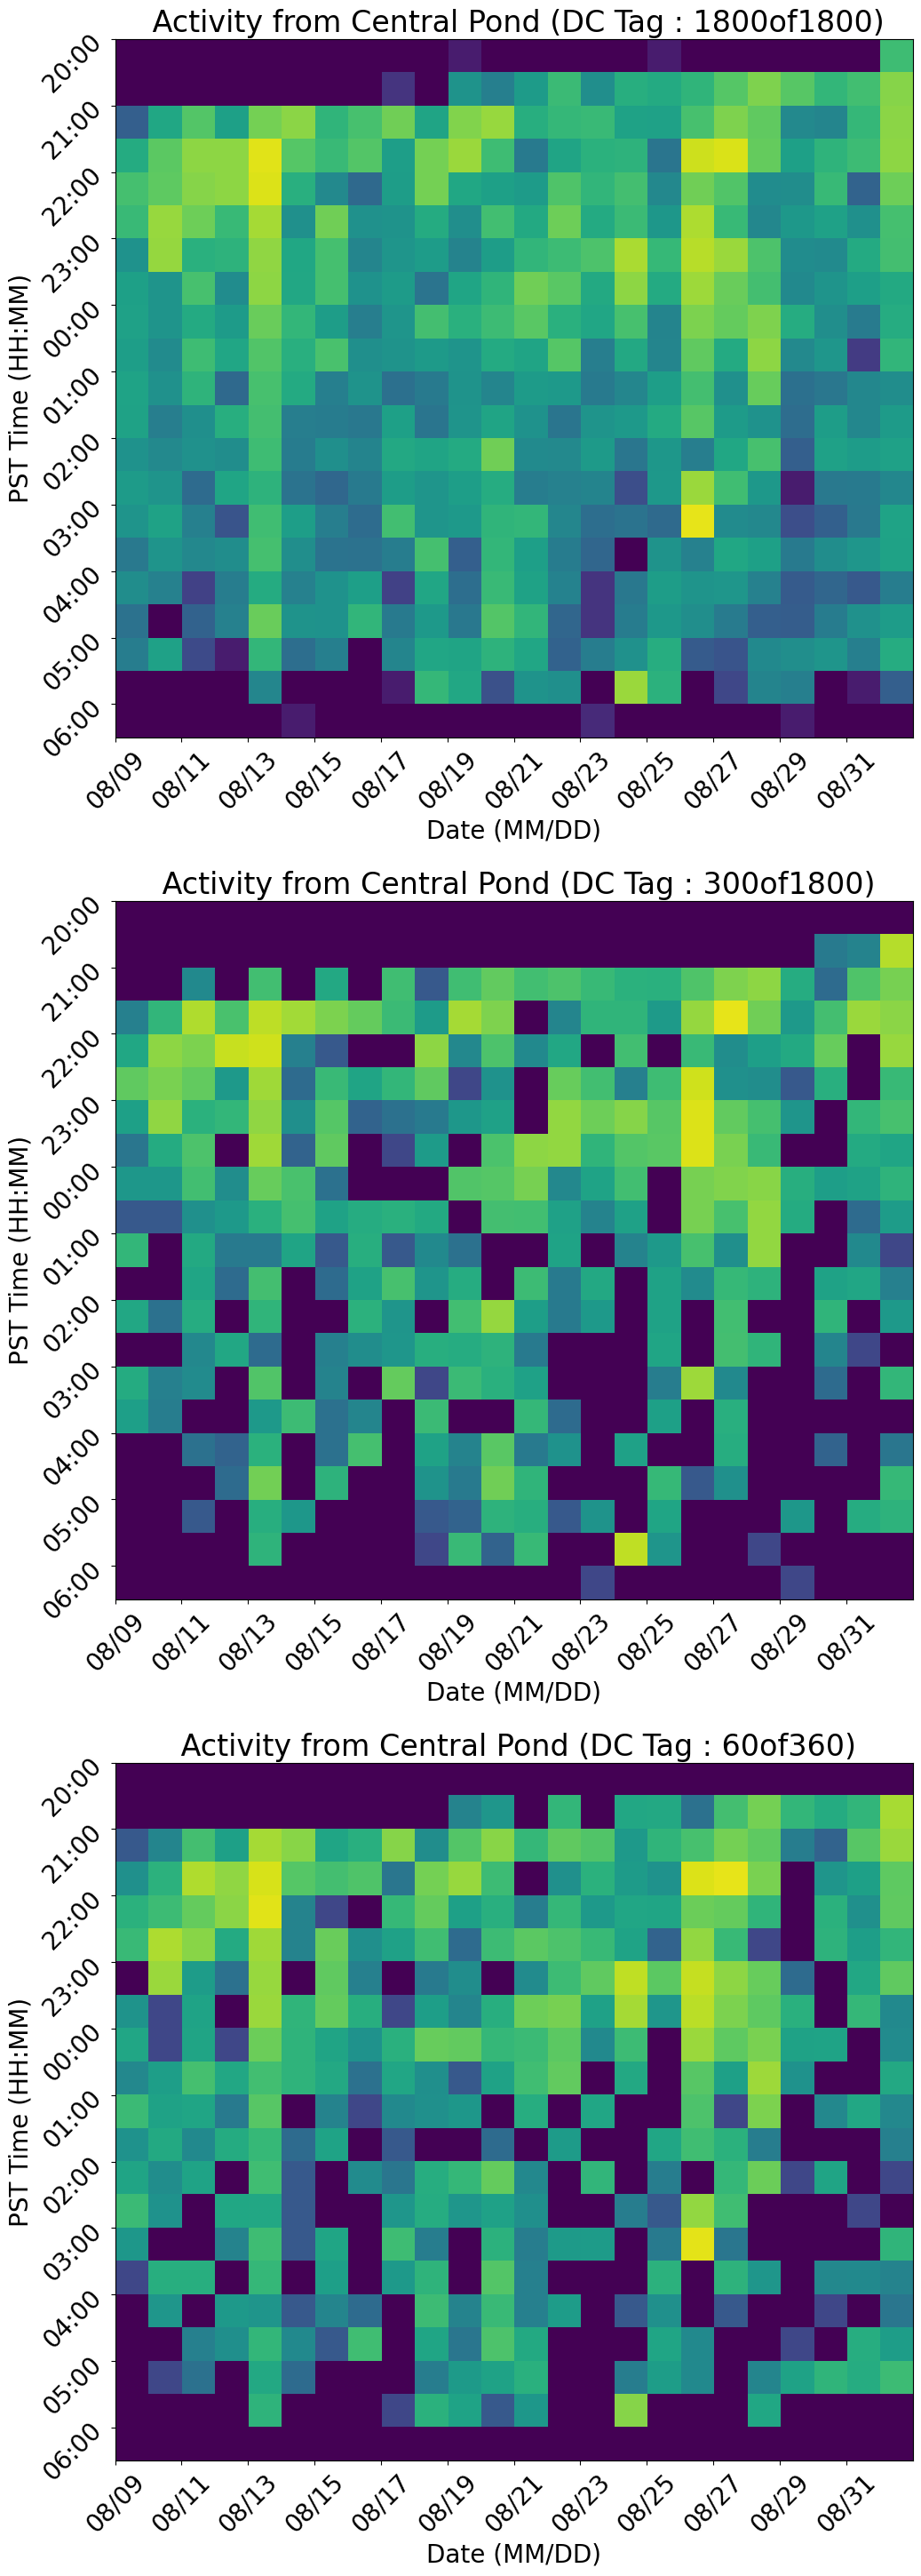

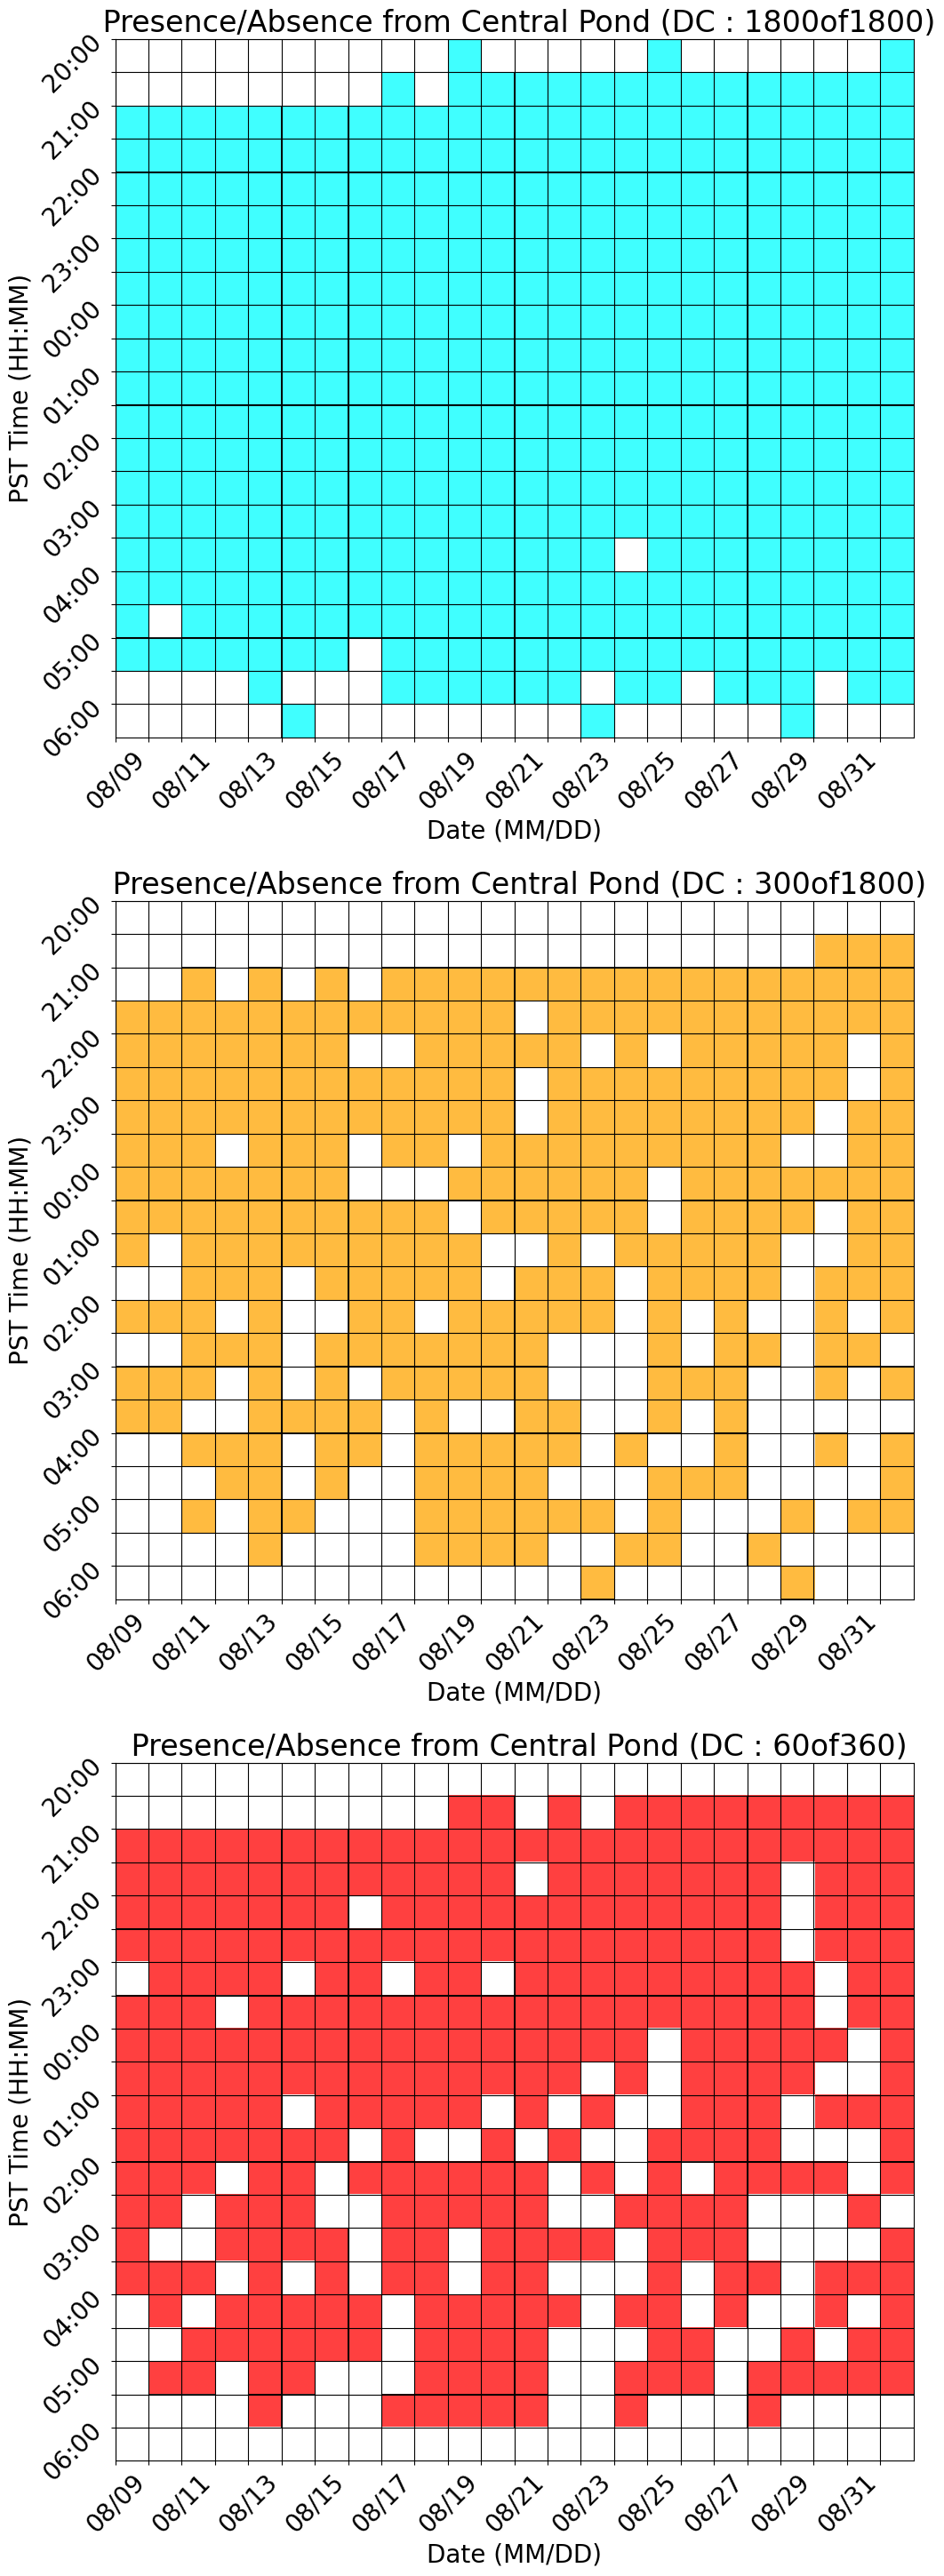

In [11]:
pipeline.plot(activity_arr, data_params, pipeline_params, file_paths)